In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import keras.backend as K

Using TensorFlow backend.


In [2]:
K.set_floatx('float16')

## Load images in grayscale

In [3]:
images = [cv2.imread(file,0) for file in glob.glob("data/*.jpg")]

In [4]:
images[0].shape

(64, 64)

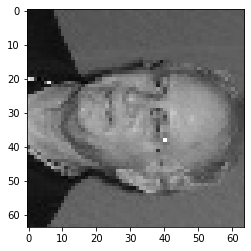

In [5]:
plt.imshow(images[2],cmap = plt.cm.gray) 

## Removing Noise with gaussian blur

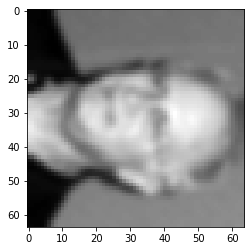

In [6]:
images_b = []
for i in range(len(images)):
    blur = cv2.GaussianBlur(images[i], (5, 5), 0)
    images_b.append(blur)


plt.imshow(images_b[2],cmap = plt.cm.gray)

## Load target values

In [7]:
target = pd.read_csv('./data/train.truth.csv')

In [8]:
target.head()

,fn,label
0,0-10049200_1891-09-16_1958.jpg,rotated_left
1,0-10110600_1985-09-17_2012.jpg,rotated_left
2,0-10126400_1964-07-07_2010.jpg,upright
3,0-1013900_1917-10-15_1960.jpg,rotated_right
4,0-10166400_1960-03-12_2008.jpg,upside_down


In [9]:
set(target['label'].values)

{'rotated_left', 'rotated_right', 'upright', 'upside_down'}

## One hot encoding target

In [10]:
LE = LabelEncoder()
integer_encoded = LE.fit_transform(target['label'])

In [11]:
print(integer_encoded[:10])
#left -> 0 , upright -> 2 , rotated_right -> 1,upside_down -> 3,

[0 0 2 1 3 0 0 0 3 2]


In [12]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
encoded_target = onehot_encoder.fit_transform(integer_encoded)

/home/leo/.local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [13]:
encoded_target[1]

array([1., 0., 0., 0.])

## Split into train and test data

In [14]:
len(images_b)

48896

In [15]:
train_x,test_x,train_y,test_y = train_test_split(images_b,encoded_target,test_size = 0.3)

train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)


In [16]:
train_x = train_x.reshape(34227,64,64,-1)
test_x = test_x.reshape(14669,64,64,-1)

#using -1 numpy infers shape

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(34227, 64, 64, 1)
(14669, 64, 64, 1)
(34227, 4)
(14669, 4)


## Float16 for faster training

In [17]:
train_x = train_x.astype('float16')
train_y = train_y.astype('float16')
test_x = test_x.astype('float16')
test_y = test_y.astype('float16')

In [18]:
train_x /= 255
test_x /= 255


## CNN creation

In [20]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                        input_shape=(64, 64, 1), activation='relu'))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid'))


In [23]:
from keras.optimizers import SGD

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
__________

In [ ]:
model.fit(train_x,train_y,
          
              batch_size=32,
              epochs= 10,
              validation_data = (test_x,test_y),
              shuffle=True,
              verbose=2)

W0725 14:52:09.851905 139848620762944 deprecation.py:323] From /home/leo/.local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 34227 samples, validate on 14669 samples
Epoch 1/10
